# Experiment: Discrimination Task

**NOTE:** If you get error "TypeError: argument of type 'float' is not iterable" then some NA columns need to be removed manually from results CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from collections import OrderedDict

In [2]:
def get_results (file_list, reverseLum=[False,False,False,False,False], redresults=[False,False,False,False,False]):
    '''
    file_list = list of [filename].csv in the final_results dir
    reverseLum = list with True or False for whether luminance was defined backwards
    redresults = whether the results are from the Red Image folder (which for some reason has LumVal0 being white...)
    '''
    results_list = []
    for i, fn in enumerate(file_list):
        if redresults[i]:
            ctrl = 0
        else:
            ctrl = 1
        df = pd.read_csv('PsychoPyExperiment/final_results/'+fn+'.csv')
        df['accuracy'] = [1 if df['corrans'][i]==df['resp.keys'][i] else 0 for i in range(df.shape[0])]
        df['lumval'] = [float(fn.split('LumVal')[1].split('_')[0]) if '_changed' in fn else ctrl for fn in df['imagestim']]
        if reverseLum[i]:
            df['lumval'] = 1-df['lumval']
        results_list.append(df)
    return(results_list)


def plot_results (results_list, colors, labels, save_name, smoothen=True, show=True):
    '''
    results_list = output from get_results
    colors = list of colors to use in plot
    labels = list of names of each result
    save_name = filename base to save images/plots
    smoothen = whether to use sav_gol filter
    '''
    # compute median, lower quartile, and upper quartile (along with accuracy)
    medians_raw_list = []
    medians_list = []
    uq_list = []
    lq_list = []
    accuracy_raw_list = []
    accuracy_list = []
    for df in results_list:
        medians_raw = []
        medians = []
        uq = []
        lq = []
        accuracy_raw = []
        accuracy = []
        for val in np.unique(df['lumval']):
            val_df = df[df['lumval']==val]
            accuracy_raw.append(np.mean(val_df['accuracy']))
            accuracy.append(np.mean(val_df['accuracy']))
            val_df_onlyaccurate = val_df[val_df['accuracy'] == 1]
            if val_df_onlyaccurate.shape[0] == 0:
                medians.append(np.nan)
                medians_raw.append(np.nan)
                lq.append(np.nan)
                uq.append(np.nan)
            else:
                medians.append(np.median(val_df_onlyaccurate['resp.rt']))
                medians_raw.append(np.median(val_df_onlyaccurate['resp.rt']))
                lq.append(np.percentile(val_df_onlyaccurate['resp.rt'],25))
                uq.append(np.percentile(val_df_onlyaccurate['resp.rt'],75))
        if smoothen is True:
            # lvcf imputation:
            for idx in np.arange(len(medians)):
                if np.isnan(medians[idx]):
                    medians[idx] = medians[idx-1]
            for idx in np.arange(len(uq)):
                if np.isnan(uq[idx]):
                    uq[idx] = uq[idx-1]
            for idx in np.arange(len(lq)):
                if np.isnan(lq[idx]):
                    lq[idx] = lq[idx-1]
            # Sav_gol filter for smoothing
            medians = scipy.signal.savgol_filter(medians, 9, 3)
            uq = scipy.signal.savgol_filter(uq, 9, 3)
            lq = scipy.signal.savgol_filter(lq, 9, 3)
            accuracy = scipy.signal.savgol_filter(accuracy[:-1], 9, 3)
        medians_raw_list.append(medians_raw)
        medians_list.append(medians)
        uq_list.append(uq)
        lq_list.append(lq)
        accuracy_raw_list.append(accuracy_raw)
        accuracy_list.append(accuracy)
    
    # plot response times
    plt.figure()
    for i, df in enumerate(results_list):
        plt.plot(np.unique(df['lumval']),medians_raw_list[i],".",markersize=10,color=colors[i])
        plt.plot(np.unique(df['lumval'])[:16],medians_list[i][:16],color=colors[i], linewidth=1.5, label=labels[i])
        plt.fill_between(np.unique(df['lumval'])[:16],lq_list[i][:16], uq_list[i][:16], color=colors[i], alpha=0.1)  
    plt.ylabel("Response time (s)",fontsize=16)
    plt.xlabel(r'Disk luminance, $\mu$',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,1)
    plt.ylim(0.39,2.01)
    plt.gca().invert_xaxis()
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='upper right',fontsize=14)
    plt.tight_layout()
    plt.savefig("./Figures/human_results/Discrimination_Task/"+save_name+"_RT.png", dpi=800)
    if show is True:
        plt.show()
    else:
        plt.close()

    # plot accuracies
    plt.figure()
    for i, df in enumerate(results_list):
        plt.plot(np.unique(df['lumval'])[:-1],accuracy_raw_list[i][:len(accuracy_raw_list[i])-1],".",markersize=10,color=colors[i])
        if smoothen is True:
            plt.plot(np.unique(df['lumval'])[:-1],accuracy_list[i],color=colors[i],linewidth=1.5, label=labels[i])
        else:
            plt.plot(np.unique(df['lumval'])[:-1],accuracy_list[i][:len(accuracy_list[i])-1],color=colors[i],linewidth=1.5, label=labels[i])
    plt.ylabel("Accuracy",fontsize=16)
    plt.xlabel(r'Disk luminance, $\mu$',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0,1)
    plt.ylim(-0.01,1.01)
    plt.gca().invert_xaxis()
    plt.legend(loc='lower right',fontsize=14)
    plt.tight_layout()
    plt.savefig("./Figures/human_results/Discrimination_Task/"+save_name+"_ACC.png", dpi=800)
    if show is True:
        plt.show()
    else:
        plt.close()
    
    return(medians_raw_list, accuracy_raw_list)

## Final Plots

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


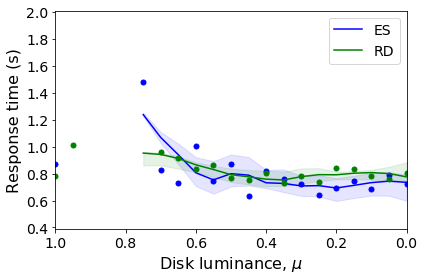

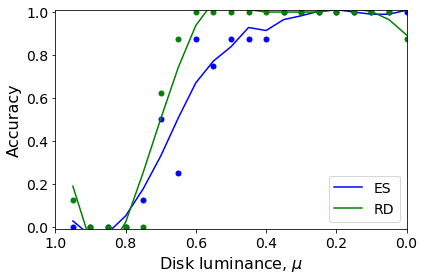

In [34]:
# No Lines
results = get_results(['NL_Flash_NoTranslate_2021_Jul_06_0020','RD_NL_Flash_NoTranslate'],[False,False])
mlist, alist = plot_results(results, colors=['b','g'], labels=['ES', 'RD'], save_name='FINAL_NoLines',smoothen=True)

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


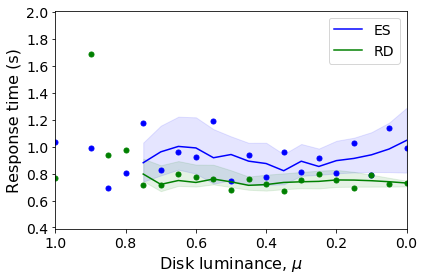

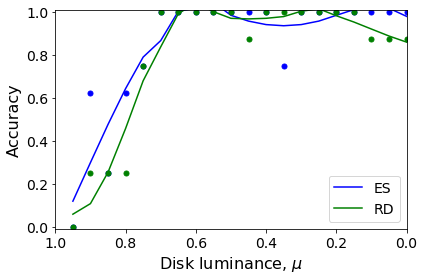

In [33]:
# Scintillating Grid
results = get_results(['SG_Flash_NoTranslate_2021_Jul_06_0006','RD_SG_Flash_NoTranslate'],[False,False])
mlist, alist = plot_results(results, colors=['b','g'], labels=['ES', 'RD'], save_name='FINAL_Illusion',smoothen=True)

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


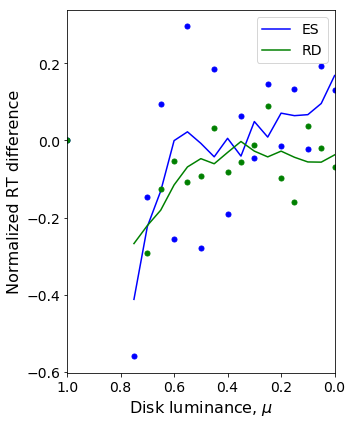

In [32]:
# Plot normalized RT differences
results = get_results(['NL_Flash_NoTranslate_2021_Jul_06_0020','SG_Flash_NoTranslate_2021_Jul_06_0006'],[False,False])
mlist, alist = plot_results(results, colors=['b','g'], labels=['NL', 'SG'], save_name='test',smoothen=False,show=False)

# Normalize by RT at mu = 1.0 (white disk)
mlist1_norm = mlist[1]/mlist[1][-1]
mlist0_norm = mlist[0]/mlist[0][-1]

# Plot difference
plt.figure(figsize=(5,6))
diff = mlist1_norm-mlist0_norm
plt.plot(np.arange(0,1.05,0.05),diff,".",markersize=10,color="b")
for idx in np.arange(len(diff)):
    if np.isnan(diff[idx]):
        diff[idx] = diff[idx-1]
smooth_diff = scipy.signal.savgol_filter(diff, 9, 3)
plt.plot(np.arange(0,0.8,0.05),smooth_diff[:16],linewidth=1.5,color="b",label="ES")

results = get_results(['RD_NL_Flash_NoTranslate','RD_SG_Flash_NoTranslate'],[False,False])
mlist, alist = plot_results(results, colors=['b','g'], labels=['NL', 'SG'], save_name='test',smoothen=False,show=False)

# Normalize by RT at mu = 1.0 (white disk)
mlist1_norm = mlist[1]/mlist[1][-1]
mlist0_norm = mlist[0]/mlist[0][-1]

# Plot difference
diff = mlist1_norm-mlist0_norm
plt.plot(np.arange(0,1.05,0.05),diff,".",markersize=10,color="g")
for idx in np.arange(len(diff)):
    if np.isnan(diff[idx]):
        diff[idx] = diff[idx-1]
smooth_diff = scipy.signal.savgol_filter(diff, 9, 3)
plt.plot(np.arange(0,0.8,0.05),smooth_diff[:16],linewidth=1.5,color="g",label="RD")


plt.ylabel("Normalized RT difference",fontsize=16)
plt.xlabel(r'Disk luminance, $\mu$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.legend(loc='best',fontsize=14)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig("./Figures/human_results/Discrimination_Task/FINAL_DIFF.png", dpi=800)
plt.show()

C:\Users\edsun\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


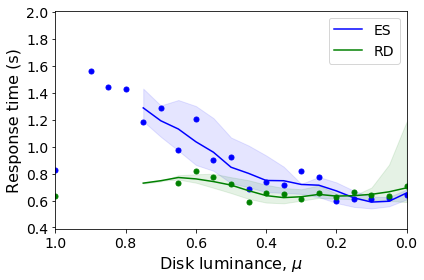

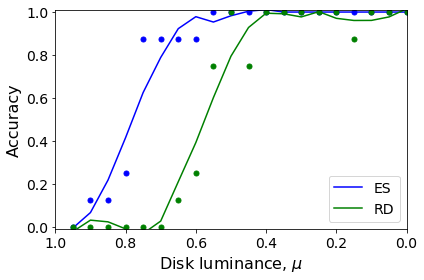

In [3]:
# No Lines
results = get_results(['NL_NoFlash_NoTranslate_2021_Jul_06_2305','RD_NL_NoFlash_NoTranslate'],[False,False])
mlist, alist = plot_results(results, colors=['b','g'], labels=['ES', 'RD'], save_name='FINAL_NoLines_NoFlash',smoothen=True)